<a href="https://colab.research.google.com/github/ChenHY1217/Projects-In-MLAI/blob/main/ProjectsInMLAIhw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Learning

## Task1 - Decision Tree Classifier Implementation

### Dataset Preparation

We will be using the same dataset from HW1 - credit card fraud detection.

Link to dataset: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import kagglehub

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

# load dataset
df = pd.read_csv(path + "/creditcard.csv")

# Dropping high VIF features and scaling
scaler = StandardScaler()
df['Time_Scaled'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
X = df.drop(['Time', 'Amount', 'Class'], axis=1)
y = df['Class']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Using Colab cache for faster access to the 'creditcardfraud' dataset.
X_train shape: (227845, 29)
X_test shape: (56962, 29)
y_train shape: (227845,)
y_test shape: (56962,)


### Implementation

Implementing Decision Tree Classifier using sklearn

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.76      0.74        98

    accuracy                           1.00     56962
   macro avg       0.86      0.88      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9990695551420246


<Figure size 600x500 with 0 Axes>

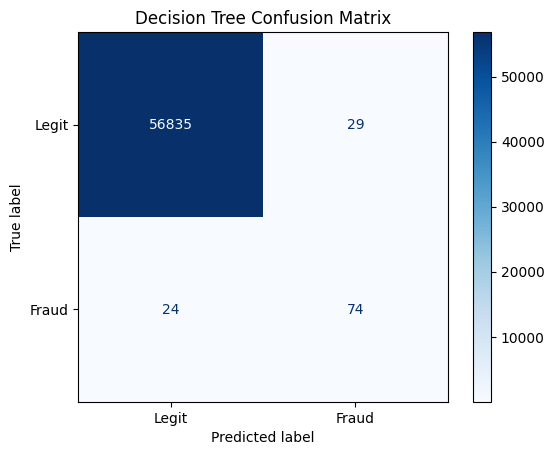

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Train
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Evaluate
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Fraud'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Decision Tree Confusion Matrix")
plt.grid(False)
plt.show()



Visualize Tree Structure

To accomplish this task, we will train three models with varying complexities.

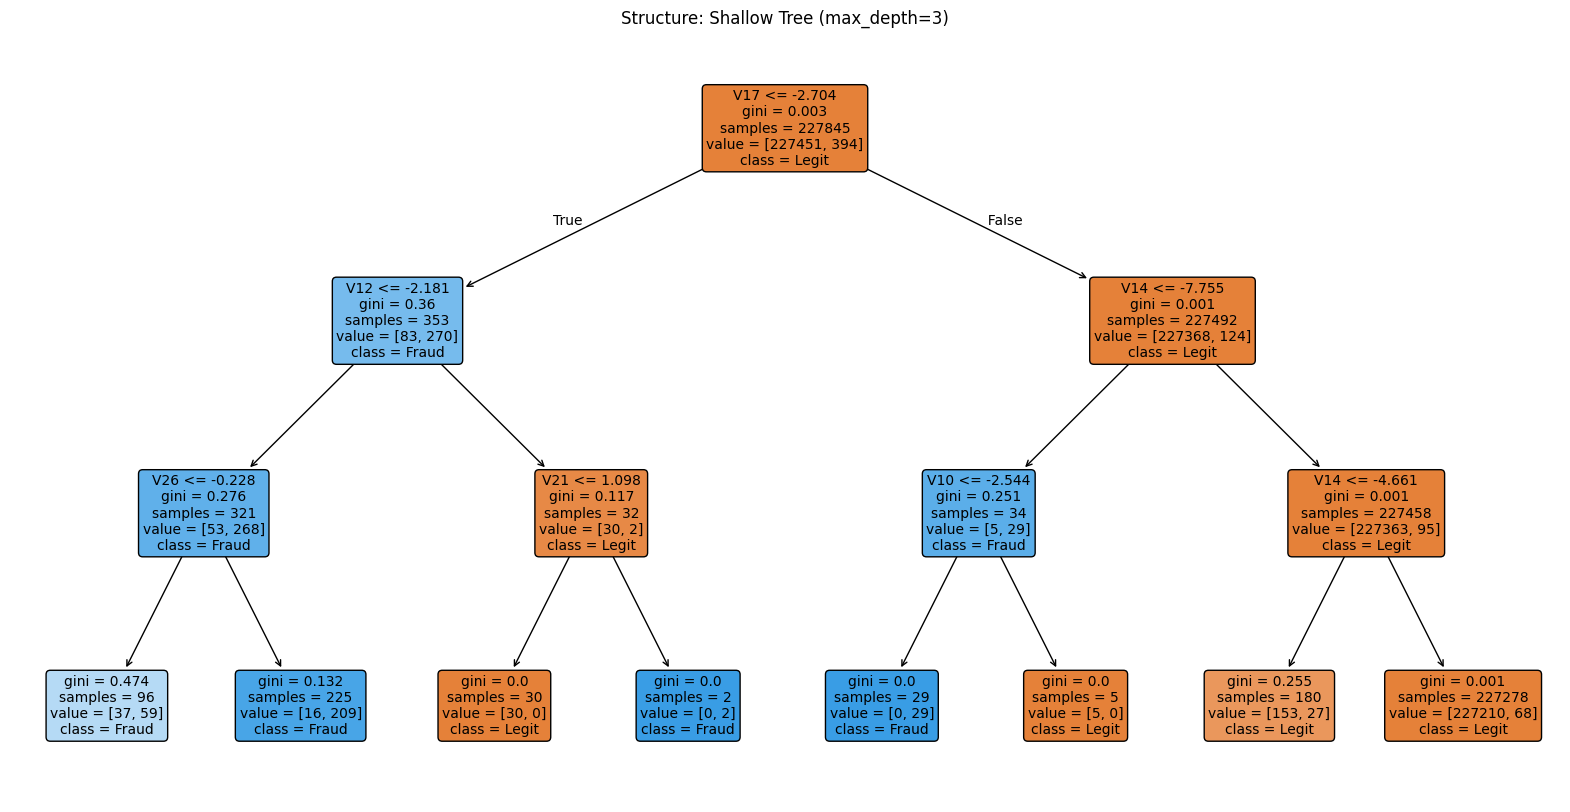

Shallow Tree (max_depth=3) - Actual Depth: 3, Leaf Nodes: 8


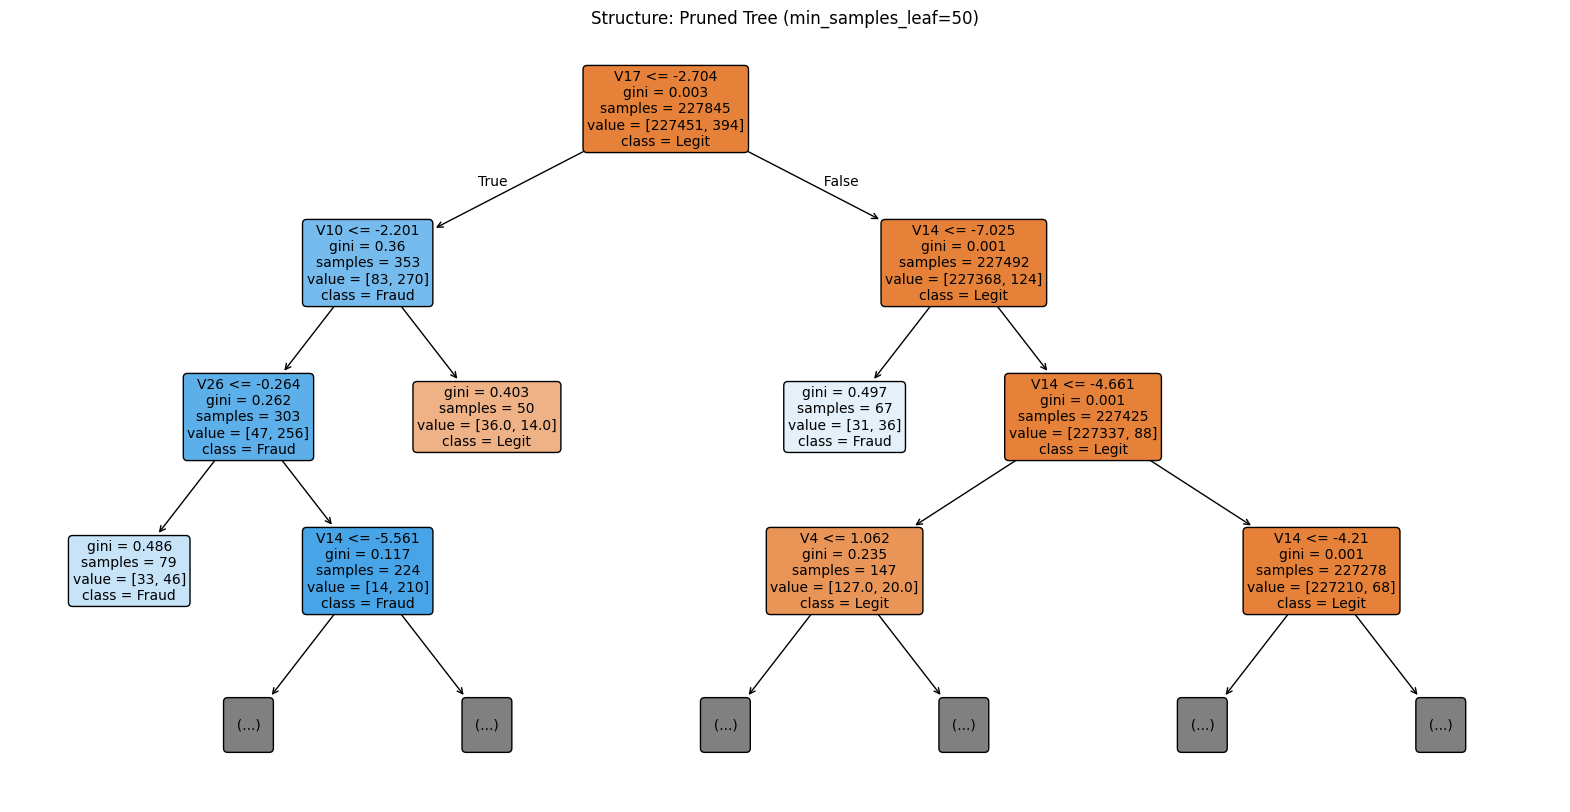

Pruned Tree (min_samples_leaf=50) - Actual Depth: 22, Leaf Nodes: 82


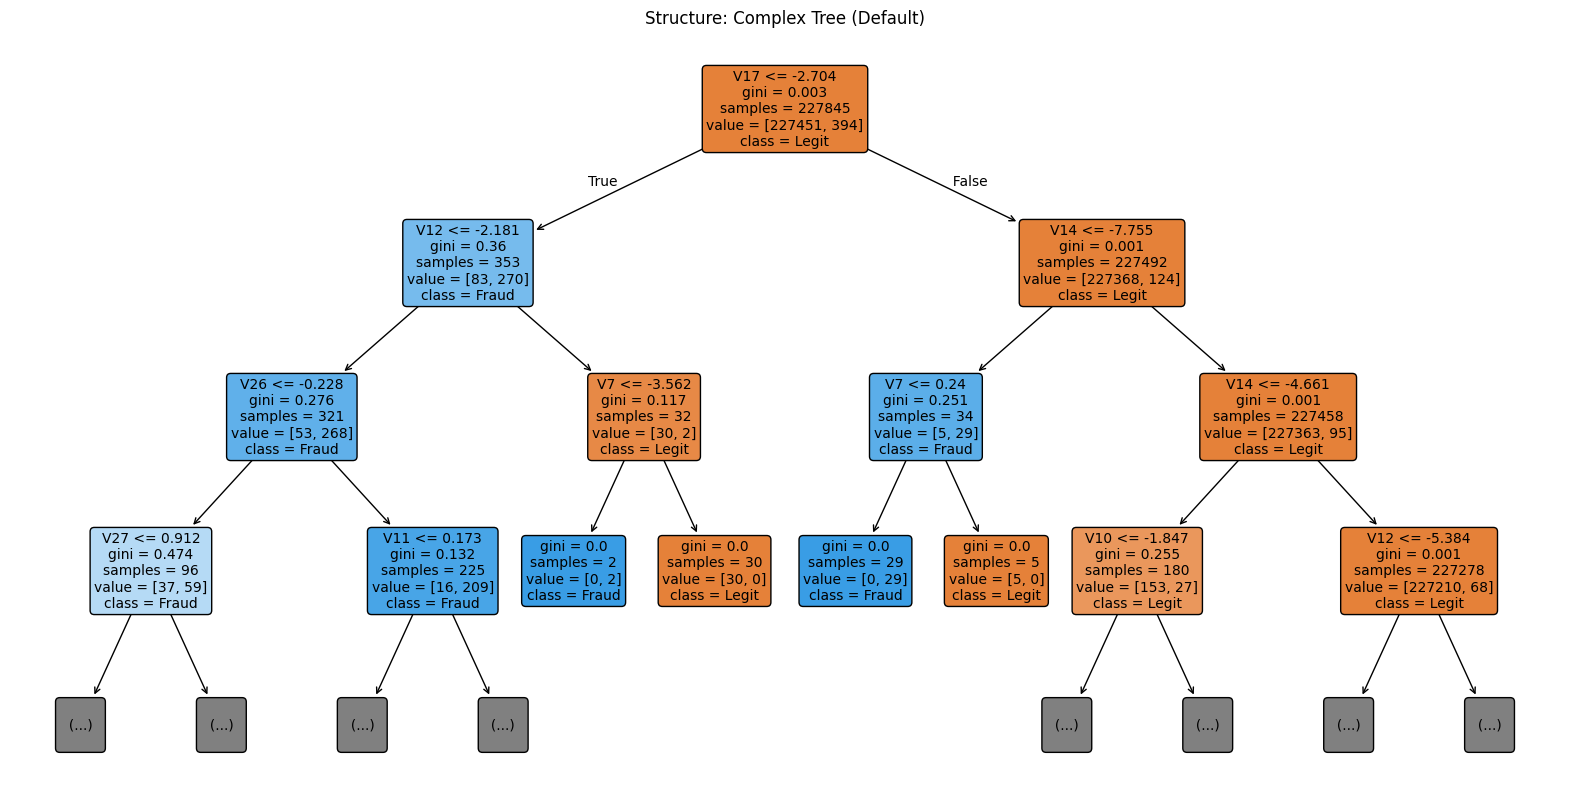

Complex Tree (Default) - Actual Depth: 26, Leaf Nodes: 163


In [ ]:
from sklearn.tree import plot_tree

# define models
models = [
    ("Shallow Tree (max_depth=3)", DecisionTreeClassifier(max_depth=3, random_state=42)),
    ("Pruned Tree (min_samples_leaf=50)", DecisionTreeClassifier(min_samples_leaf=50, random_state=42)),
    ("Complex Tree (Default)", DecisionTreeClassifier(random_state=42))
]

# Plotting each Tree model
for name, model in models:
    model.fit(X_train, y_train)

    plt.figure(figsize=(20, 10))
    plot_tree(model,
              feature_names=X.columns,
              class_names=['Legit', 'Fraud'],
              filled=True,
              rounded=True,
              max_depth=3,
              fontsize=10)
    plt.title(f"Structure: {name}")
    plt.show()
    print(f"{name} - Actual Depth: {model.get_depth()}, Leaf Nodes: {model.get_n_leaves()}")

Comments on Depth and Complexity:

Depth: The default tree with unrestricted depth is significantly deeper compared to the other restricted trees. Depth affects how much branching occurs and impacts the complexity of the model.

Complexity: We take a look at the number of branching and leaf nodes. We see that the default tree has a significantly large amount of leaf nodes compared to the other trees. This can lead to overfitting. Meanwhile, the shallow tree is ignoring many features to reach a fast decision.

### Sensitivity Analysis

This is the study of how variations in input features impact the model's output uncertainty and predictions. In Machine Learning, we are interested in how "sensitive" the model's prediction is to changes in specific input features.

For this dataset, we will perform a sensitivity analysis on two input features V4 and V14.

Citations:
* https://towardsdatascience.com/the-sensitivity-analysis-a-powerful-yet-underused-tool-for-data-scientists-e553fa695976/
* https://machinelearningmastery.com/sensitivity-analysis-of-dataset-size-vs-model-performance/
* https://scikit-learn.org/stable/modules/partial_dependence.html


Generating Sensitivity Analysis (Partial Dependence Plots)...


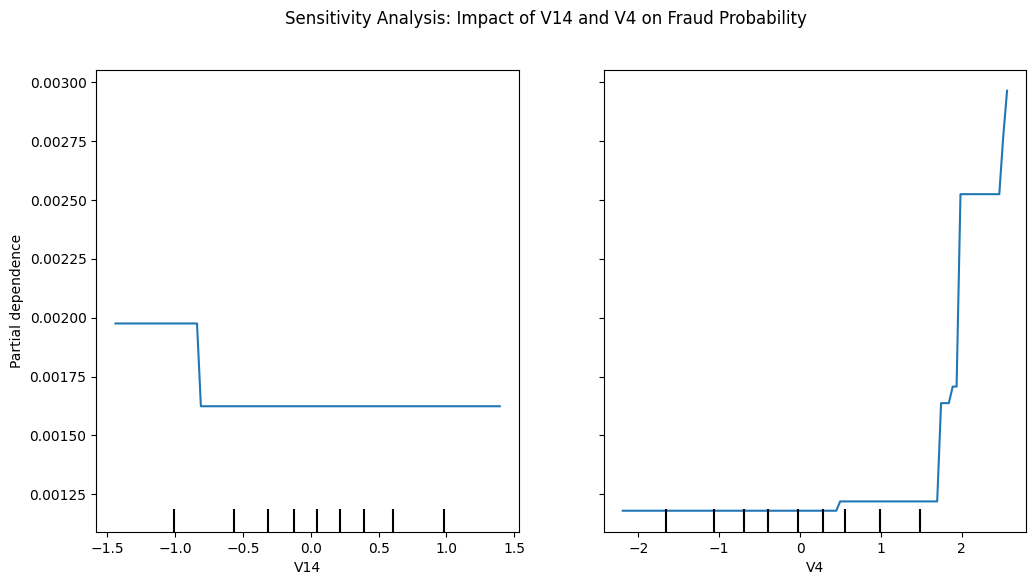

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

features_to_analyze = ['V14', 'V4']

print("Generating Sensitivity Analysis (Partial Dependence Plots)...")

fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    dt,
    X_train,
    features_to_analyze,
    kind='average',
    ax=ax
)
plt.suptitle('Sensitivity Analysis: Impact of V14 and V4 on Fraud Probability')
plt.show()

We performed a sensitivity analysis on the above features using Partial Dependence Plots from sklearn.

The plot for V4 shows a steep vertical rise, suggesting high sensitivity. This means that minor variations around the edge of the rise can drastically alter the classification outcome. Meanwhile, V14 has a steep drop but proceeds to be flat. This means that this feature is robust to changes within the majority of the range.

## Task 2 - Bagging and Boosting

We will be implementing Random Forest and AdaBoost as the Bagging and Boosting algorithms.

We will apply stratified k-fold CV. In contrast to standard k-fold CV which just splits data randomly into k groups, this ensures that each fold has the same proportions in terms of the labels with respect to the whole dataset. This is especially important for an imbalanced dataset like this one. This guarantees that each fold has fraud cases.

Note: during execution, the model was taking a very long time due to the internal implementations of AdaBoost and Random Forest. Therefore, the workaround was to reduce the k-values.

Citations:
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
* https://www.geeksforgeeks.org/machine-learning/stratified-k-fold-cross-validation/


In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# Random Forest (Bagging)
rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)

# AdaBoost (Boosting)
ada_model = AdaBoostClassifier(n_estimators=20, random_state=42)

models = {
    "Random Forest (Bagging)": rf_model,
    "AdaBoost (Boosting)": ada_model
}

k_values = [3, 5, 7]

scoring_metrics = ['accuracy', 'precision', 'f1']

results_data = []

print("Starting Stratified K-Fold Evaluation...")

for k in k_values:
    # Initialize Stratified K-Fold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for model_name, model in models.items():
        print(f"Running {model_name} with k={k}...")

        # Perform Cross-Validation
        cv_results = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring_metrics, n_jobs=-1)

        # Store average scores
        results_data.append({
            "Algorithm": model_name,
            "K-Folds": k,
            "Avg Accuracy": np.mean(cv_results['test_accuracy']),
            "Avg Precision": np.mean(cv_results['test_precision']),
            "Avg F1-Score": np.mean(cv_results['test_f1'])
        })

# Display Results
results_df = pd.DataFrame(results_data)
print("\nTask 2 Evaluation Results:")
display(results_df) # Use print(results_df) if not in Jupyter

Starting Stratified K-Fold Evaluation...
Running Random Forest (Bagging) with k=3...
Running AdaBoost (Boosting) with k=3...
Running Random Forest (Bagging) with k=5...
Running AdaBoost (Boosting) with k=5...
Running Random Forest (Bagging) with k=7...
Running AdaBoost (Boosting) with k=7...

Task 2 Evaluation Results:


,Algorithm,K-Folds,Avg Accuracy,Avg Precision,Avg F1-Score
0,Random Forest (Bagging),3,0.999513,0.941413,0.844528
1,AdaBoost (Boosting),3,0.999074,0.772125,0.710879
2,Random Forest (Bagging),5,0.999486,0.930514,0.836846
3,AdaBoost (Boosting),5,0.999105,0.782774,0.719842
4,Random Forest (Bagging),7,0.999504,0.938919,0.841407
5,AdaBoost (Boosting),7,0.999070,0.755422,0.714678


The above are the results from doing stratified k-fold CV. We see the Avg Accuracy, Avg Precision, and Avg F1-score for each model and k-fold combination.

Under Accuracy, we see that both model has high accuracy with minor differences. However, this is misleading since the data is severely imbalanced. Therefore, we need to focus on F1-score and precision.

When we look at Precision and F1-score, we see that Random Forest is the clear winner. This is because Bagging algorithms are better at balancing precision vs recall. AdaBoost on the other hand struggles to generalize, resulting in a lower F1-score.

## Task 3 - Comparison of Models

citations:
* https://www.jmp.com/en/statistics-knowledge-portal/t-test/paired-t-test

Confusion Matrix on One Test Fold

Fold Data Dimensions: Train=(182276, 29), Test Fold=(45569, 29)
Training Decision Tree...
Training Random Forest...
Training AdaBoost...


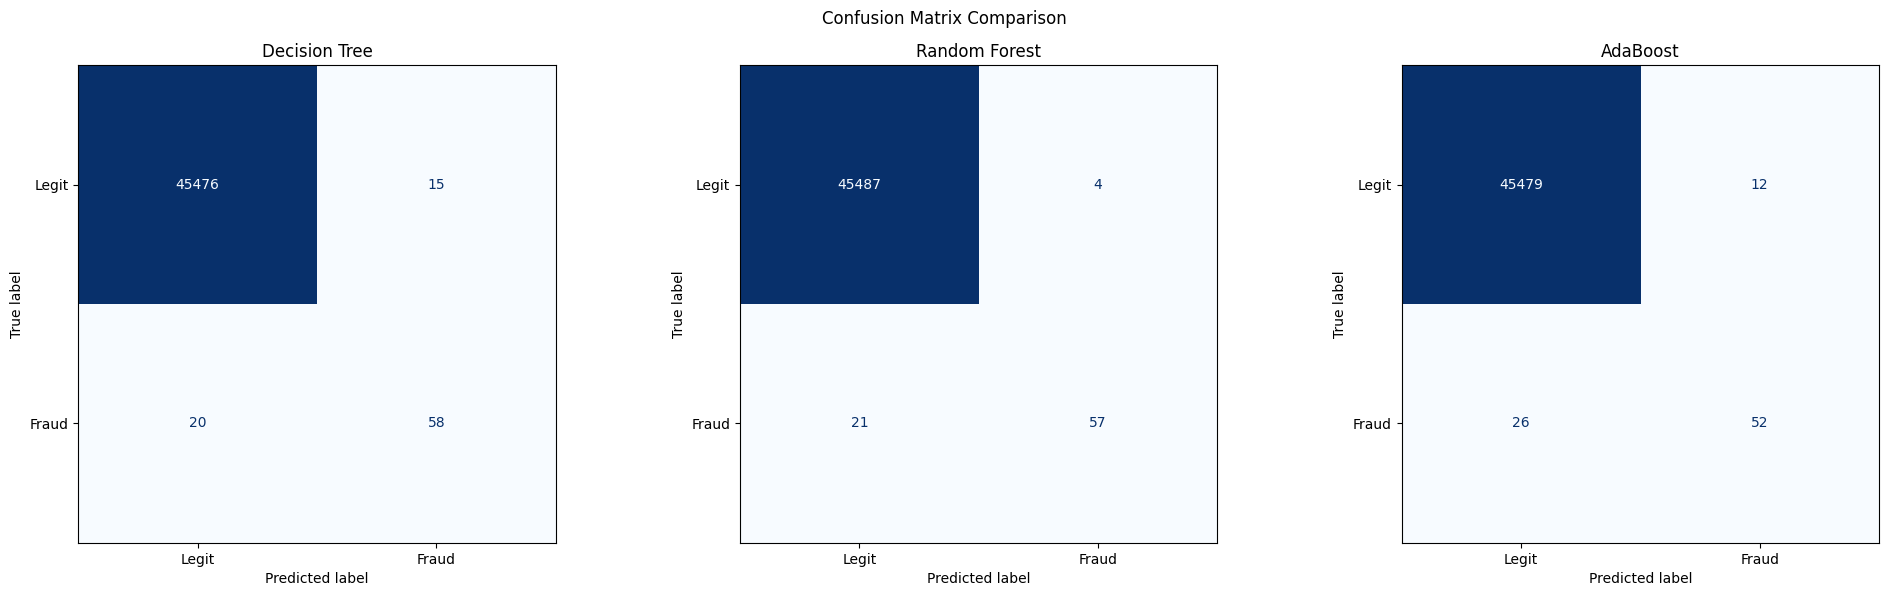

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

# Extract one test fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_fold_idx = next(skf.split(X_train, y_train))

X_fold_train = X_train.iloc[train_idx]
y_fold_train = y_train.iloc[train_idx]
X_fold_test  = X_train.iloc[test_fold_idx]
y_fold_test  = y_train.iloc[test_fold_idx]

print(f"Fold Data Dimensions: Train={X_fold_train.shape}, Test Fold={X_fold_test.shape}")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for axis, (name, model) in zip(axes, models.items()):
    print(f"Training {name}...")
    model.fit(X_fold_train, y_fold_train)
    y_pred = model.predict(X_fold_test)

    cm = confusion_matrix(y_fold_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Fraud'])
    disp.plot(ax=axis, cmap='Blues', colorbar=False)
    axis.set_title(name)

plt.suptitle("Confusion Matrix Comparison")
plt.tight_layout()
plt.show()



We see that overall there is no drastic difference. But, we see that there is much less legit cases being predicted as fraud and similar number of false positives too. Therefore, random forest is still superior compared to the other models.

Paired T test for model comparison among folds

In [ ]:
from scipy import stats
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

print("Starting Paired T-Test Evaluation...")

for name, model in models.items():
    print(f"Running {name}...")
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    results[name] = scores
    print(f"{name} - F1 Scores: {scores}")

# Paired t test
pairs = [
    ("Decision Tree", "Random Forest"),
    ("Decision Tree", "AdaBoost"),
    ("Random Forest", "AdaBoost")
]

print("Paired T-Test Results:")
for model_1, model_2 in pairs:
    t_statistic, p_value = stats.ttest_rel(results[model_1], results[model_2])

    sig = "Significant" if p_value < 0.05 else "Not Significant"
    print(f"{model_1} vs {model_2}:")
    print(f"T-Statistic: {t_statistic}")
    print(f"P-Value: {p_value:.5f} ({sig})")

Starting Paired T-Test Evaluation...
Running Decision Tree...
Decision Tree - F1 Scores: [0.76821192 0.78378378 0.75641026 0.72316384 0.81578947]
Running Random Forest...
Random Forest - F1 Scores: [0.82014388 0.86330935 0.82758621 0.85333333 0.84507042]
Running AdaBoost...
AdaBoost - F1 Scores: [0.73239437 0.70503597 0.70588235 0.7625     0.70921986]
Paired T-Test Results:
Decision Tree vs Random Forest:
T-Statistic: -4.301776352144632
P-Value: 0.01263 (Significant)
Decision Tree vs AdaBoost:
T-Statistic: 1.88546870251536
P-Value: 0.13244 (Not Significant)
Random Forest vs AdaBoost:
T-Statistic: 8.856603482234895
P-Value: 0.00090 (Significant)


We see that Decision Tree vs Random Forest and Random Forest vs AdaBoost has significant differences according to the p-values.

Bias and Variance Tradeoff

For the standard single decision tree, it has low bias because of its ability to learn every detail of the training data and overfit. This in return yields high variance as this tree is prone to overfitting and slight changes to the training data yields can yield a completely different structure. Therefore, we will likely see high accuracy on Train data but lower on Test data.

For Random Forest, we are training many deep trees and since we are taking a smaller subset of the training data to train, it will have slightly higher bias. However, because we are averaging trees, we have reduced varaince. This keeps the flexibility of the tree while maintaining stability.

For AdaBoost, we have lower bias because we start with a weak model and iteratively fix errors. However, this can yield high variance as we are focusing on fixing errors and difficult examples and may mistake noise. This has a potential of overfitting.

##

## Task - Implementing XGBoost

### Implementation and Hyperparameter Tuning

We will perform hyperparameter tuning for 4 parameters that each have a range of values.

We will perform RandomSearchCV for the tuning.

citations:
* https://www.jeremyjordan.me/hyperparameter-tuning/

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report
from scipy.stats import uniform, randint
import pandas as pd
import matplotlib.pyplot as plt

# Use XGBoost with GPU
xgb_model = XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    tree_method='hist',
    device='cuda'
)

# build the tuning grid
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Starting Randomized Search CV / Hyperparameter Tuning...")
random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)

best_xgb_model = random_search.best_estimator_

y_pred = best_xgb_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

results_df = pd.DataFrame(random_search.cv_results_)

Starting Randomized Search CV / Hyperparameter Tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:32:05] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:32:05] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters: {'learning_rate': np.float64(0.12236203565420874), 'max_depth': 7, 'n_estimators': 64, 'subsample': np.float64(0.8659969709057025)}
Best F1 Score: 0.8540488293245995

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.81      0.85        98

    accuracy                           1.00     56962
   macro avg       0.95      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962



Results for best hyperparameter and model is shown above.

### Sensitivity Analysis

We will assess the sensitivity of the model to changes to parameters.

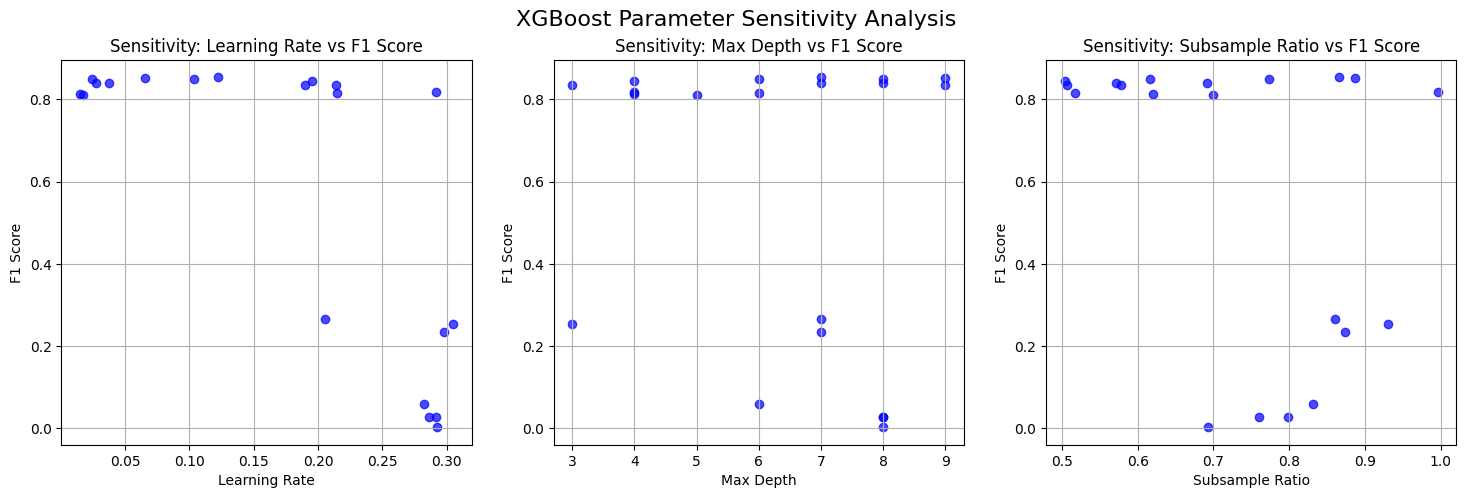

In [3]:
# Create a figure with subplots for each parameter
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Parameters to analyze
params_to_plot = ['param_learning_rate', 'param_max_depth', 'param_subsample']
labels = ['Learning Rate', 'Max Depth', 'Subsample Ratio']

for ax, param, label in zip(axes, params_to_plot, labels):
    # Scatter plot: Parameter Value vs. Mean Test Score (F1)
    ax.scatter(results_df[param], results_df['mean_test_score'], c='blue', alpha=0.7)

    ax.set_title(f"Sensitivity: {label} vs F1 Score")
    ax.set_xlabel(label)
    ax.set_ylabel("F1 Score")
    ax.grid(True)

plt.suptitle("XGBoost Parameter Sensitivity Analysis", fontsize=16)
plt.show()

<Figure size 1000x800 with 0 Axes>

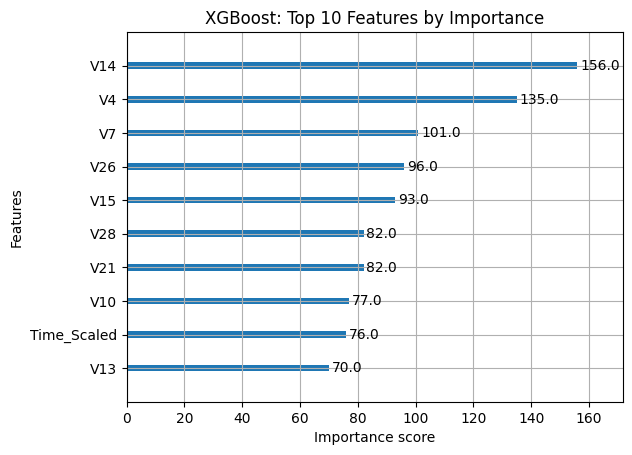

In [6]:
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(random_search.best_estimator_, max_num_features=10, importance_type='weight')
plt.title("XGBoost: Top 10 Features by Importance")
plt.show()